In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import urllib.request, json
import requests
import urllib.parse
import datetime

# Retrieve DOC Admission and Discharge Data from NYC Open Data Portal

### Socrata API urls:

* Inmate Admission: `https://data.cityofnewyork.us/resource/6teu-xtgp.json`

* Inmate Discharges: `https://data.cityofnewyork.us/resource/94ri-3ium.json`

Both of these datasets are unique on the inmate identification number `INMATEID`. We are going to count the number of inmates admitted and discharges daily from 2016 to May 1, 2023 using the SODA SQL language.

In [11]:
admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'
dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'

def get_data(url):
    query = (url+'?'
            "$select=*"
            "&$limit=500000")
    query = query.replace(" ", "%20")
    response = urllib.request.urlopen(query)
    data = json.loads(response.read())
    
    #store in dataframe
    df = pd.DataFrame(data,columns = data[0].keys())
    
    return df

In [12]:
admissions = get_data(admit_url)

In [13]:
admissions.head()

,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge
0,10008773,2018-08-23T10:15:28.000,2018-08-23T11:14:00.000,UNKNOWN,M,DE,VTL 1192.3
1,20037818,2018-08-05T19:13:46.000,2018-08-10T16:46:05.000,UNKNOWN,M,DE,NaN
2,20197484,2018-08-14T02:08:36.000,NaN,BLACK,F,DE,120.05
3,20150289,2018-08-02T00:05:22.000,NaN,UNKNOWN,M,DPV,NaN
4,20122449,2018-08-23T18:34:24.000,NaN,UNKNOWN,M,DE,120.05


In [14]:
admissions.describe()

,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge
count,379027,379027,294861,379027,377998,379027,133488
unique,173579,368160,289818,3,2,8,630
top,20064261,2016-05-22T12:32:00.000,2019-02-19T16:00:00.000,BLACK,M,DE,155.25
freq,51,7,6,209820,344180,277766,14077


In [15]:
discharges = get_data(dis_url)
discharges.head()

,inmateid,admitted_dt,discharged_dt,race,gender,age,inmate_status_code,top_charge
0,20190778,2018-05-30T15:38:41.000,2018-08-16T06:12:04.000,UNKNOWN,M,25,CS,220.09
1,20130019,2018-02-24T20:15:24.000,2018-08-22T11:24:00.000,UNKNOWN,M,25,DE,NaN
2,41370,2018-07-30T15:58:35.000,2018-08-06T13:21:01.000,BLACK,M,49,DE,NaN
3,20035180,2018-04-30T13:34:00.000,2018-08-01T21:42:02.000,BLACK,M,49,DE,NaN
4,20115029,2018-08-31T00:39:46.000,2018-08-31T13:01:03.000,UNKNOWN,M,38,DE,NaN


In [17]:
discharges.describe()

,inmateid,admitted_dt,discharged_dt,race,gender,age,inmate_status_code,top_charge
count,381939,381939,381939,381939,381044,381293,381939,84587
unique,175421,370449,374844,3,2,81,8,571
top,20064261,2022-03-03T13:12:28.000,2019-02-19T16:00:00.000,BLACK,M,28,DE,155.25
freq,49,12,8,211381,346799,14366,276757,12982


In [18]:
admissions.dtypes

inmateid              object
admitted_dt           object
discharged_dt         object
race                  object
gender                object
inmate_status_code    object
top_charge            object
dtype: object

In [19]:
## aggregate to daily 

admissions['admitted_dt'] = pd.to_datetime(admissions['admitted_dt'])
discharges['discharged_dt'] = pd.to_datetime(discharges['discharged_dt'])

admissions['admitted_date'] = admissions['admitted_dt'].dt.date
discharges['discharged_date'] = discharges['discharged_dt'].dt.date

In [20]:
admissions.head()

,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge,admitted_date
0,10008773,2018-08-23 10:15:28,2018-08-23T11:14:00.000,UNKNOWN,M,DE,VTL 1192.3,2018-08-23
1,20037818,2018-08-05 19:13:46,2018-08-10T16:46:05.000,UNKNOWN,M,DE,NaN,2018-08-05
2,20197484,2018-08-14 02:08:36,NaN,BLACK,F,DE,120.05,2018-08-14
3,20150289,2018-08-02 00:05:22,NaN,UNKNOWN,M,DPV,NaN,2018-08-02
4,20122449,2018-08-23 18:34:24,NaN,UNKNOWN,M,DE,120.05,2018-08-23


In [23]:
daily_admits = admissions[['admitted_date','inmateid']].groupby(by = 'admitted_date').nunique()
daily_admits = daily_admits.rename(columns = {'inmateid':'Admissions'})
daily_discharges = discharges[['discharged_date','inmateid']].groupby(by = 'discharged_date').nunique()
daily_discharges = daily_discharges.rename(columns = {'inmateid':'Discharges'})
#merge
daily_counts = daily_admits.merge(daily_discharges, left_index = True, right_index = True)
daily_counts.head()

,Admissions,Discharges
admitted_date,,
2014-01-01,84,33
2014-01-02,202,217
2014-01-03,162,201
2014-01-04,107,43
2014-01-05,118,20


In [24]:
daily_counts['Gain/Loss'] = daily_counts['Admissions'] - daily_counts['Discharges']
daily_counts = daily_counts.reset_index()
daily_counts.tail()

,admitted_date,Admissions,Discharges,Gain/Loss
3402,2023-04-26,70,68,2
3403,2023-04-27,97,100,-3
3404,2023-04-28,90,121,-31
3405,2023-04-29,51,19,32
3406,2023-04-30,47,10,37


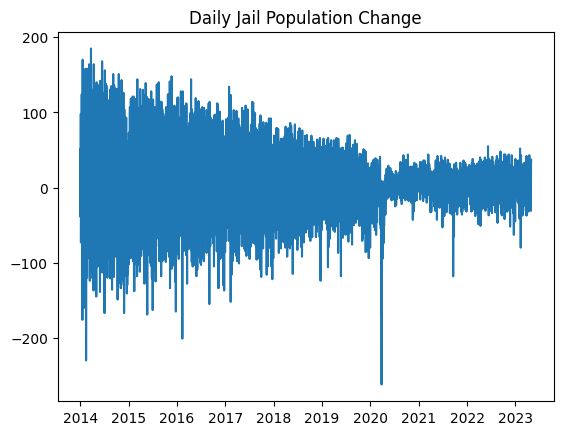

In [26]:
#visualize
plt.plot(daily_counts['admitted_date'],daily_counts['Gain/Loss'])
plt.title('Daily Jail Population Change')
plt.show()

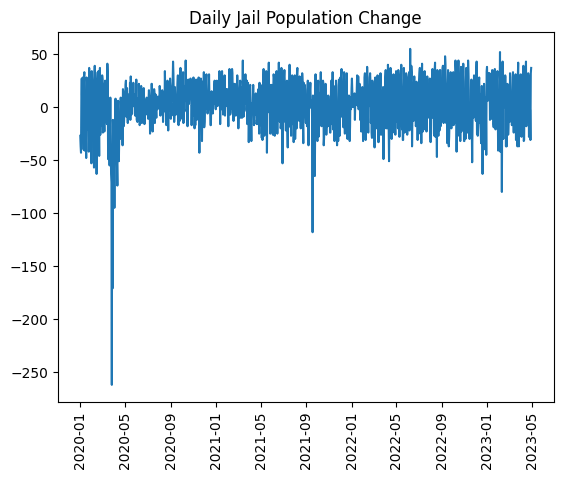

In [78]:
#plot 2020 onward
post2020 = daily_counts[pd.to_datetime(daily_counts['admitted_date']).dt.year >= 2020]
plt.plot(post2020['admitted_date'],post2020['Gain/Loss'])
plt.title('Daily Jail Population Change')
plt.xticks(rotation = 90)
plt.show()

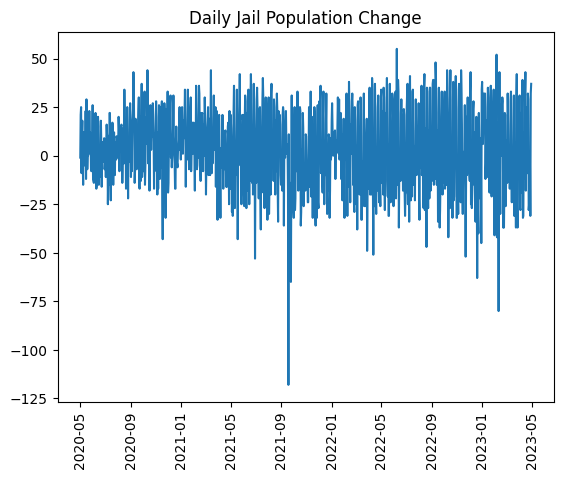

In [80]:
#lets use data from 2020-05 onward to exclude the impact of the covid 19 stay at home order
post_SHO = daily_counts[pd.to_datetime(daily_counts['admitted_date']) >= pd.to_datetime('2020-05-01')]
plt.plot(post_SHO['admitted_date'],post_SHO['Gain/Loss'])
plt.title('Daily Jail Population Change')
plt.xticks(rotation = 90)
plt.show()

In [81]:
#lets also look at weekly
admissions = admissions[admissions['admitted_dt'] >= pd.to_datetime('2020-05-01')]
discharges = discharges[discharges['discharged_dt']>= pd.to_datetime('2020-05-01')]

admissions['admitted_week'] = admissions['admitted_dt'].dt.isocalendar().week
discharges['discharged_week'] = discharges['discharged_dt'].dt.isocalendar().week

admissions['admitted_year'] = admissions['admitted_dt'].dt.isocalendar().year
discharges['discharged_year'] = discharges['discharged_dt'].dt.isocalendar().year

admissions.head()

,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge,admitted_date,admitted_week,admitted_year
325119,20192991,2020-05-29 12:12:15,NaN,BLACK,M,DE,NaN,2020-05-29,22,2020
325703,101,2020-05-15 11:00:11,NaN,UNKNOWN,M,DPV,NaN,2020-05-15,20,2020
325704,722,2020-05-11 16:36:00,NaN,UNKNOWN,M,DE,140.25,2020-05-11,20,2020
325705,1123,2020-05-01 12:37:35,NaN,BLACK,M,DPV,NaN,2020-05-01,18,2020
325706,1135,2020-05-05 18:39:11,NaN,BLACK,M,DPV,NaN,2020-05-05,19,2020


In [82]:
weekly_admits = admissions[['admitted_year','admitted_week','inmateid']].groupby(by = ['admitted_year','admitted_week']).nunique().reset_index()
weekly_admits = weekly_admits.rename(columns = {'admitted_year':'year',
                                                'admitted_week':'week',
                                                'inmateid':'Admissions'})
weekly_discharges = discharges[['discharged_year','discharged_week','inmateid']].groupby(by = ['discharged_year','discharged_week']).nunique().reset_index()
weekly_discharges = weekly_discharges.rename(columns = {'discharged_year':'year',
                                                        'discharged_week':'week',
                                                        'inmateid':'Discharges'})

#merge
weekly_counts = weekly_admits.merge(weekly_discharges, on = ['year','week'])
weekly_counts['Gain/Loss'] = weekly_counts['Admissions'] - weekly_counts['Discharges']
weekly_counts['Year-Wk'] = ['-'.join(i) for i in zip(weekly_counts["year"].map(str),weekly_counts["week"].map(str))]

weekly_counts.head()

,year,week,Admissions,Discharges,Gain/Loss,Year-Wk
0,2020,18,111,66,45,2020-18
1,2020,19,231,210,21,2020-19
2,2020,20,282,228,54,2020-20
3,2020,21,271,237,34,2020-21
4,2020,22,251,205,46,2020-22


In [83]:
weekly_counts.dtypes

year          UInt32
week          UInt32
Admissions     int64
Discharges     int64
Gain/Loss      int64
Year-Wk       object
dtype: object

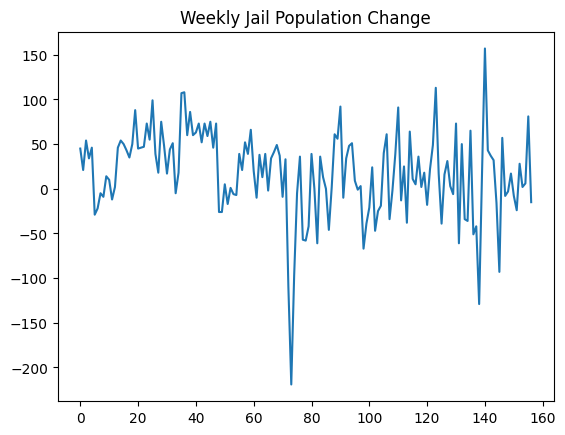

In [84]:
plt.plot(weekly_counts.index,weekly_counts['Gain/Loss'])
plt.title('Weekly Jail Population Change')
plt.show()

# Conduct Time Series Analysis on Jail Population Change


### Step 1: Trend-Seasonality-Noise decomposition

### Step 2: Stationarity and Autocorrelation

In [43]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

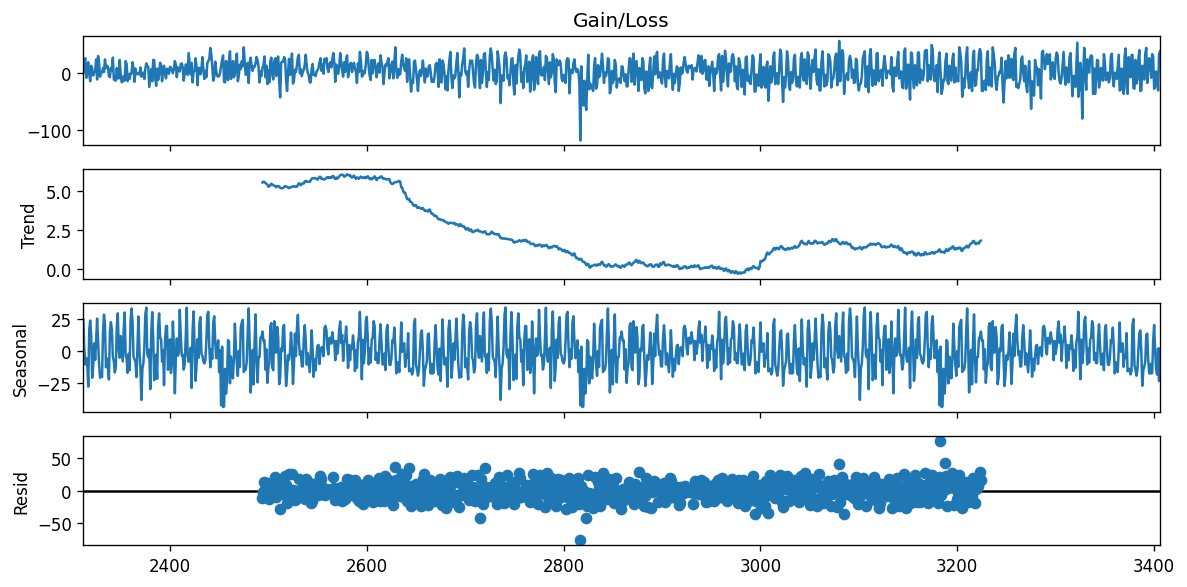

In [155]:
#Step 1: Daily trends
results = seasonal_decompose(post_SHO['Gain/Loss'],model='additive',period=365)
results.plot()
plt.show()

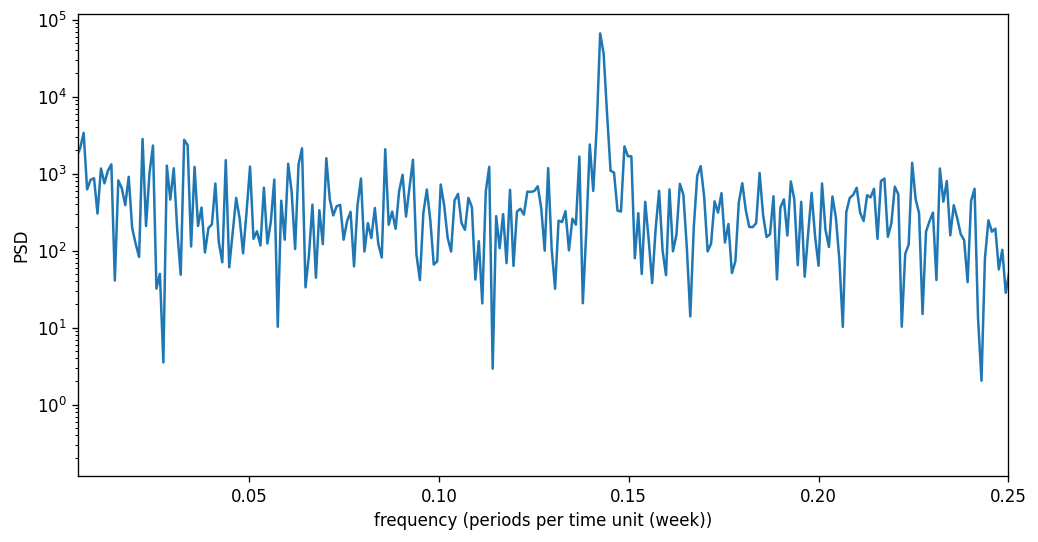

Strongest period length = 3.4984025559105434


In [152]:
#check for the optimal frequency
f, PSD = scipy.signal.periodogram(post_SHO['Gain/Loss'])
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (week))')
plt.ylabel('PSD')
plt.xlim(0.005,0.25) #show frequencies within 1/4..1/200, periods of 4-200 weeks
plt.ylim(max(PSD)/1e6,max(PSD)) #show strength up to 1e-6 of the max

#filter outputs - periods shorter than 2 years (approx 100 weeks) 
PSD = PSD[f>0.01]
f = f[f>0.01] 
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period

#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

<Figure size 960x1800 with 0 Axes>

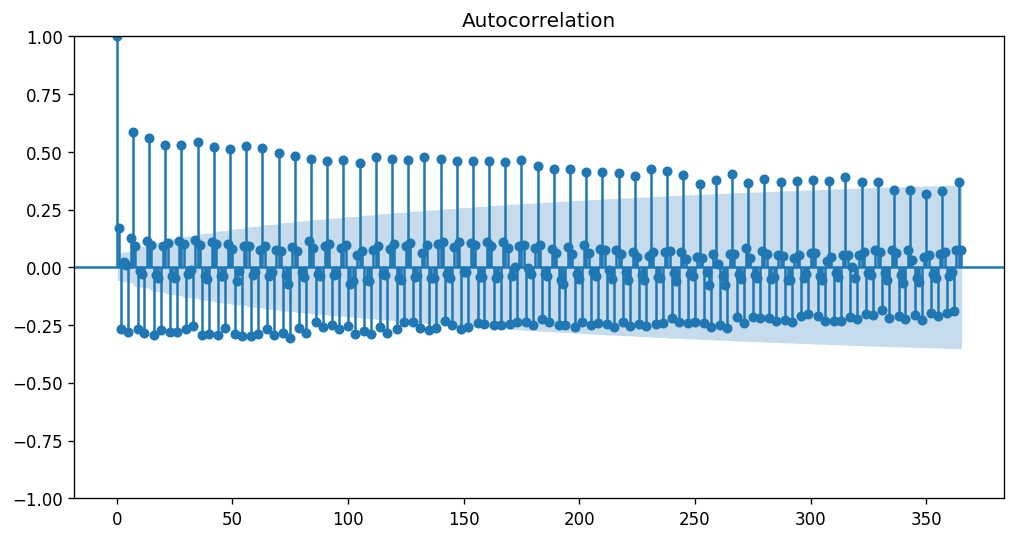

In [153]:
#plot autcorrelation for lags up to a year
plt.figure(figsize = (8,15))
plot_acf(post_SHO['Gain/Loss'], lags = 365)
plt.show()

Based on the autocorrelation graph above, we see spikes at intervals of 7 lags (weekly)

C:\Users\emjoh\AppData\Local\Temp\ipykernel_23244\3022469069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_SHO['DOY'] = pd.to_datetime(post_SHO['admitted_date']).dt.dayofyear
C:\Users\emjoh\AppData\Local\Temp\ipykernel_23244\3022469069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_SHO['year'] = pd.to_datetime(post_SHO['admitted_date']).dt.year


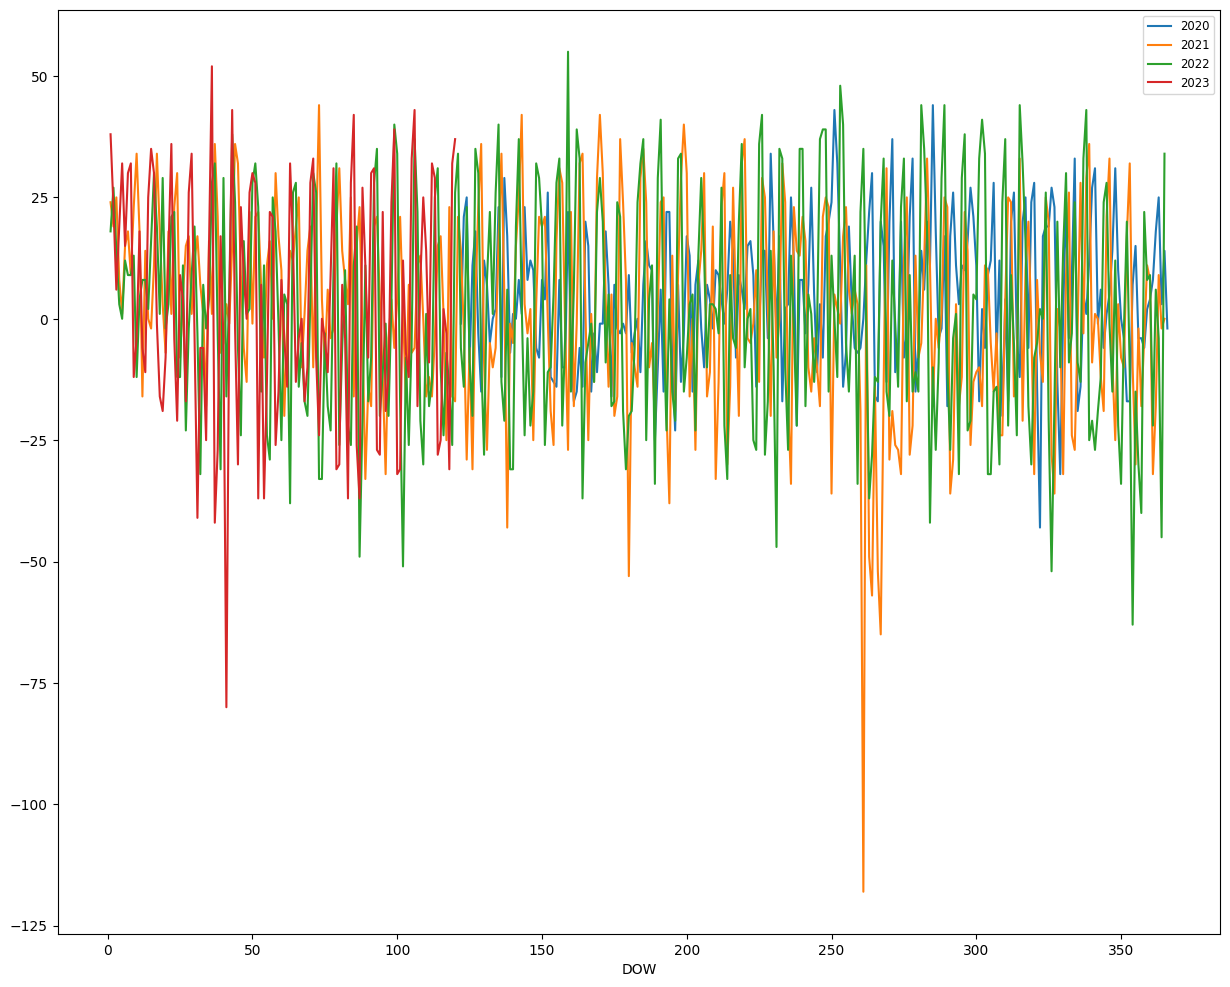

In [107]:
# let's also stack it by year
post_SHO['DOY'] = pd.to_datetime(post_SHO['admitted_date']).dt.dayofyear
post_SHO['year'] = pd.to_datetime(post_SHO['admitted_date']).dt.year

data_to_plot = post_SHO.pivot(values = 'Gain/Loss',
                              index = 'DOW',
                              columns = 'year')
#data_to_plot
fig = plt.figure(figsize = (15, 12))
data_to_plot.plot(ax = fig.add_subplot(111))
plt.legend(loc=1, fontsize = 'small')
plt.show()


Text(0.5, 1.0, 'Partial Autocorrelation')

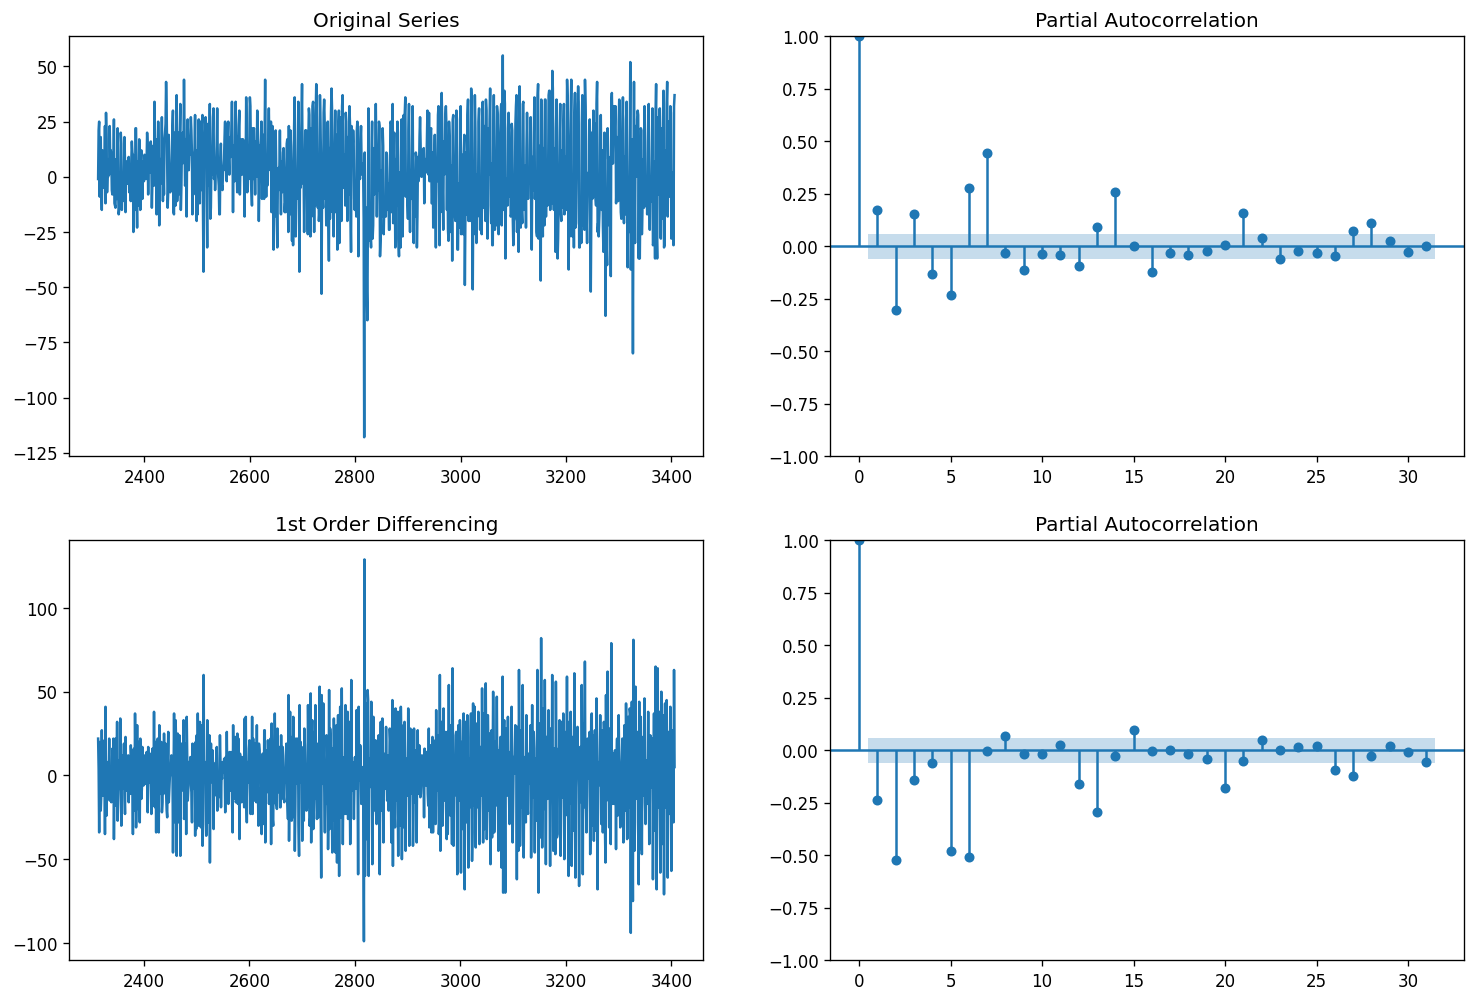

In [156]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(post_SHO['Gain/Loss']); axes[0, 0].set_title('Original Series')
plot_pacf(post_SHO['Gain/Loss'], ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(post_SHO['Gain/Loss'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(post_SHO['Gain/Loss'].diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

In [157]:
result = adfuller(post_SHO['Gain/Loss'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.350175
p-value: 0.000004
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Based on the above results from adfuller test, the time-series is stationary, so we should consider ARMA model, i.e. ARIMA with $d = 0$ or no differencing. Now we need to determine what $p$ and $q$ should be..

Recall that:

* **p:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **q:** The number of AR terms included in the model, also called the lag order.

### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Text(0.5, 1.0, 'Autocorrelation')

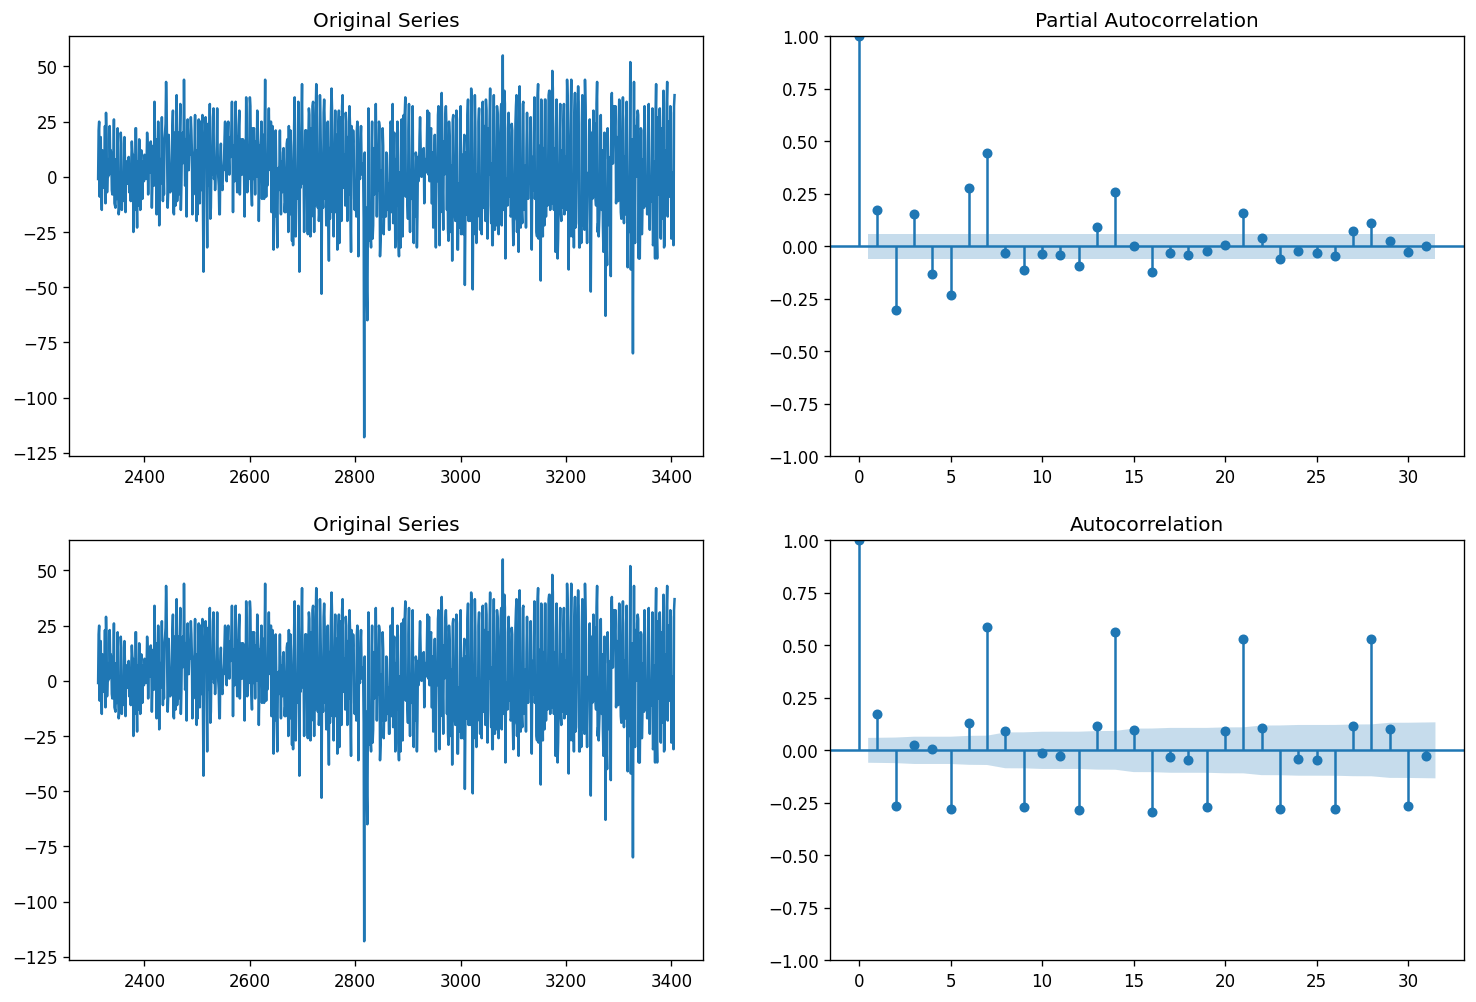

In [114]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(post_SHO['Gain/Loss']); axes[0, 0].set_title('Original Series')
plot_pacf(post_SHO['Gain/Loss'], ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(post_SHO['Gain/Loss']); axes[1, 0].set_title('Original Series')
plot_acf(post_SHO['Gain/Loss'], ax=axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

In [117]:
series = post_SHO['Gain/Loss'].reset_index(drop = True)
series.head()

0    -1
1    21
2    25
3    -9
4    11
Name: Gain/Loss, dtype: int64

In [161]:
#try ARMA(7,1) = ARIMA(7,0,1)
P=0
D=0
Q=14

# fit model
N = 365*3 - 100   
series = post_SHO['Gain/Loss'].reset_index(drop = True)

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Gain/Loss   No. Observations:                  995
Model:                ARIMA(14, 0, 0)   Log Likelihood               -4114.876
Date:                Tue, 23 May 2023   AIC                           8261.751
Time:                        16:31:37   BIC                           8340.195
Sample:                             0   HQIC                          8291.573
                                - 995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6751      1.200      2.228      0.026       0.322       5.028
ar.L1          0.1891      0.031      6.115      0.000       0.128       0.250
ar.L2         -0.0927      0.023     -4.032      0.0

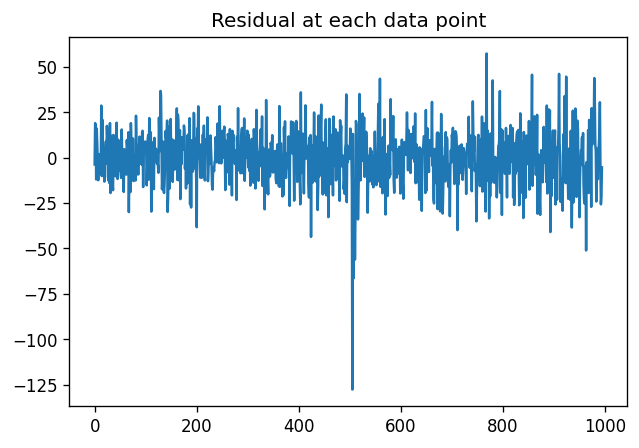

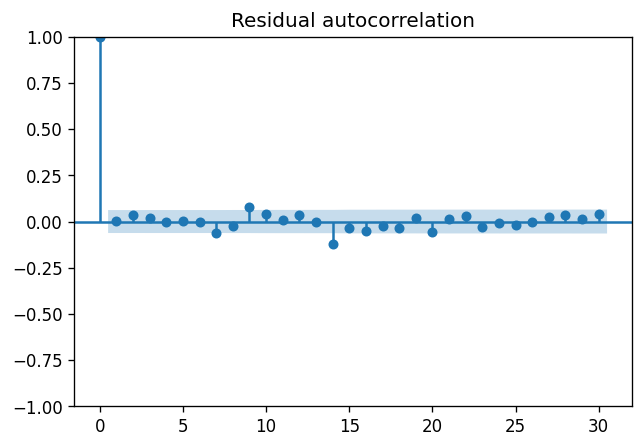

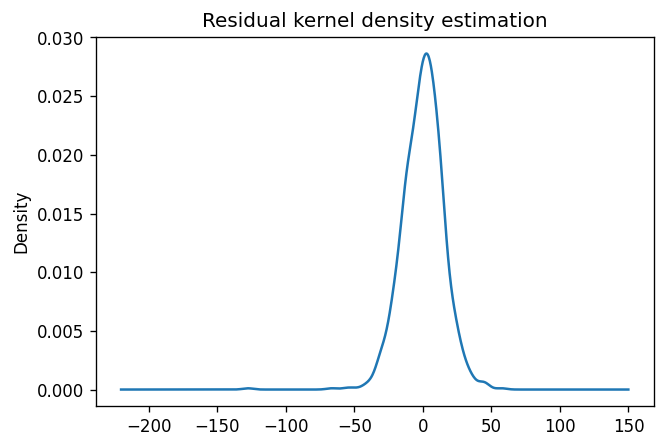

                0
count  995.000000
mean     0.017502
std     15.124259
min   -127.694555
25%     -9.074609
50%      0.827683
75%      9.582188
max     57.377449
p value is  3.5518614331335714e-42
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
      lb_stat  lb_pvalue
1    0.000362   0.984827
2    1.145872   0.563868
3    1.451229   0.693571
4    1.466850   0.832497
5    1.475964   0.915827
6    1.501453   0.959398
7    5.117181   0.645665
8    5.787612   0.671009
9   12.076247   0.209045
10  13.957725   0.174929


In [162]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


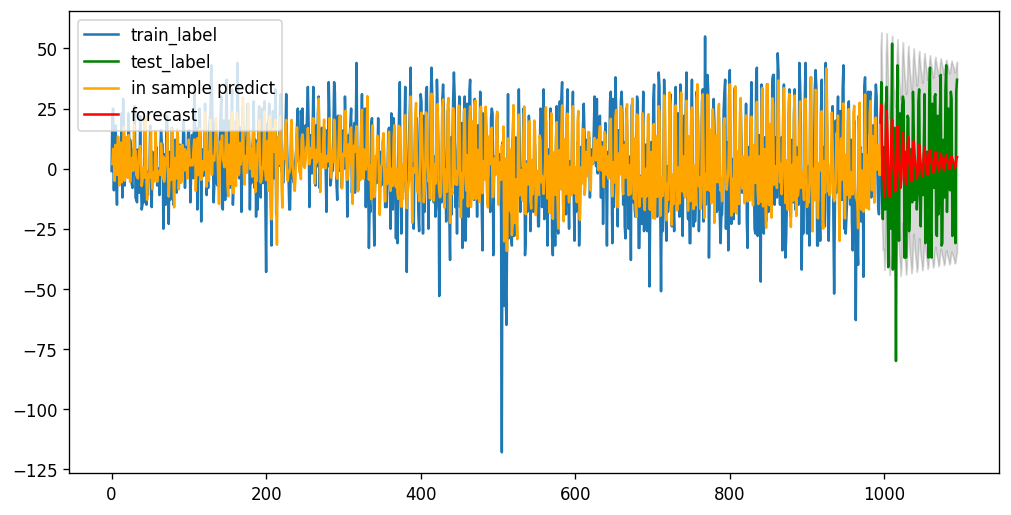

In [163]:
# Forecast
df = post_SHO.reset_index(drop = True)
fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(df.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(df.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(df.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

In [164]:
#try SARMA
P=0
D=0
Q=14

# fit model
N = 365*3 - 100   
series = post_SHO['Gain/Loss'].reset_index(drop = True)

model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P),seasonal_order=(0,0,0,7))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Gain/Loss   No. Observations:                  995
Model:              SARIMAX(14, 0, 0)   Log Likelihood               -4117.706
Date:                Tue, 23 May 2023   AIC                           8265.411
Time:                        16:32:57   BIC                           8338.952
Sample:                             0   HQIC                          8293.369
                                - 995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1959      0.031      6.312      0.000       0.135       0.257
ar.L2         -0.0868      0.023     -3.718      0.000      -0.133      -0.041
ar.L3          0.0870      0.030      2.921      0.0

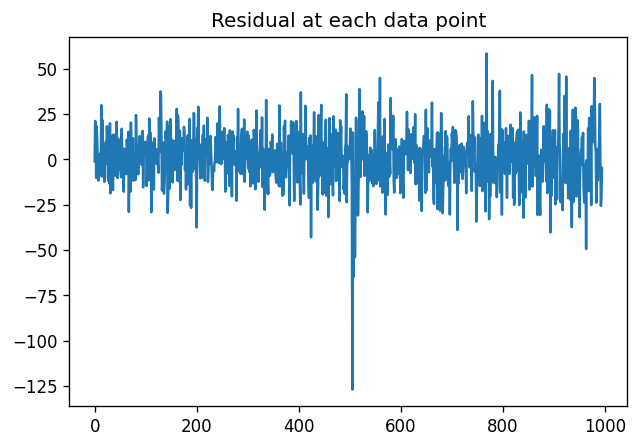

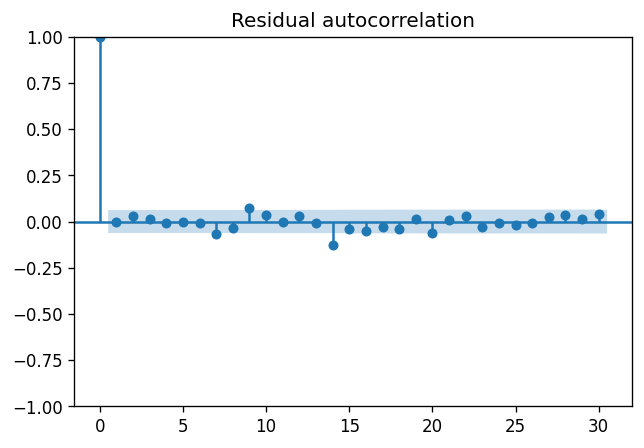

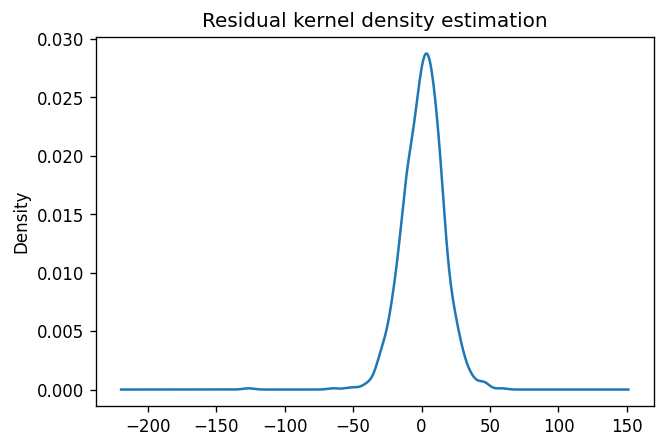

                0
count  995.000000
mean     1.022243
std     15.135374
min   -126.904951
25%     -8.203910
50%      1.661701
75%     10.322848
max     58.400238
p value is  9.960889610584262e-42
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
      lb_stat  lb_pvalue
1    0.023986   0.876920
2    0.837298   0.657935
3    0.992722   0.803013
4    1.070262   0.898961
5    1.072780   0.956485
6    1.158047   0.978906
7    5.410796   0.609964
8    6.479905   0.593637
9   11.719796   0.229571
10  13.072557   0.219643


In [165]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


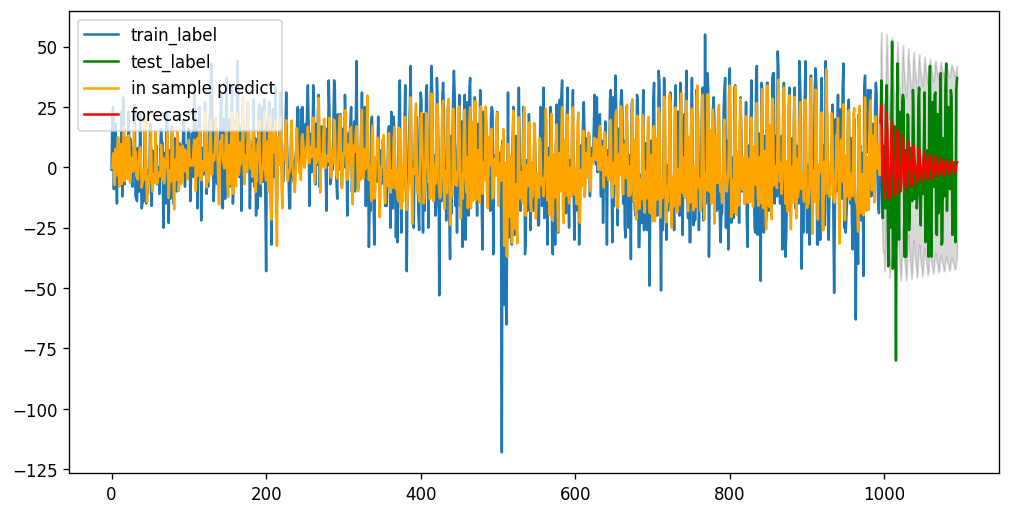

In [166]:
fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(df.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(df.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(df.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

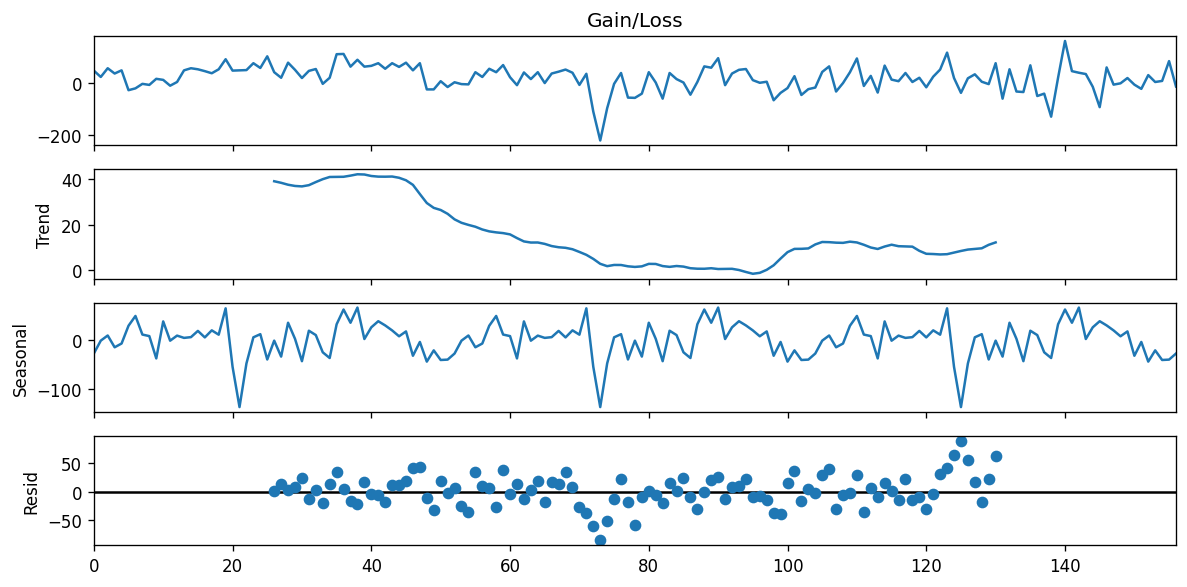

In [168]:
# try to do this on weekly trends now

#Step 1: Weekly trends
results = seasonal_decompose(weekly_counts['Gain/Loss'],model='additive',period=52)
results.plot()
plt.show()

Text(0.5, 1.0, 'Partial Autocorrelation')

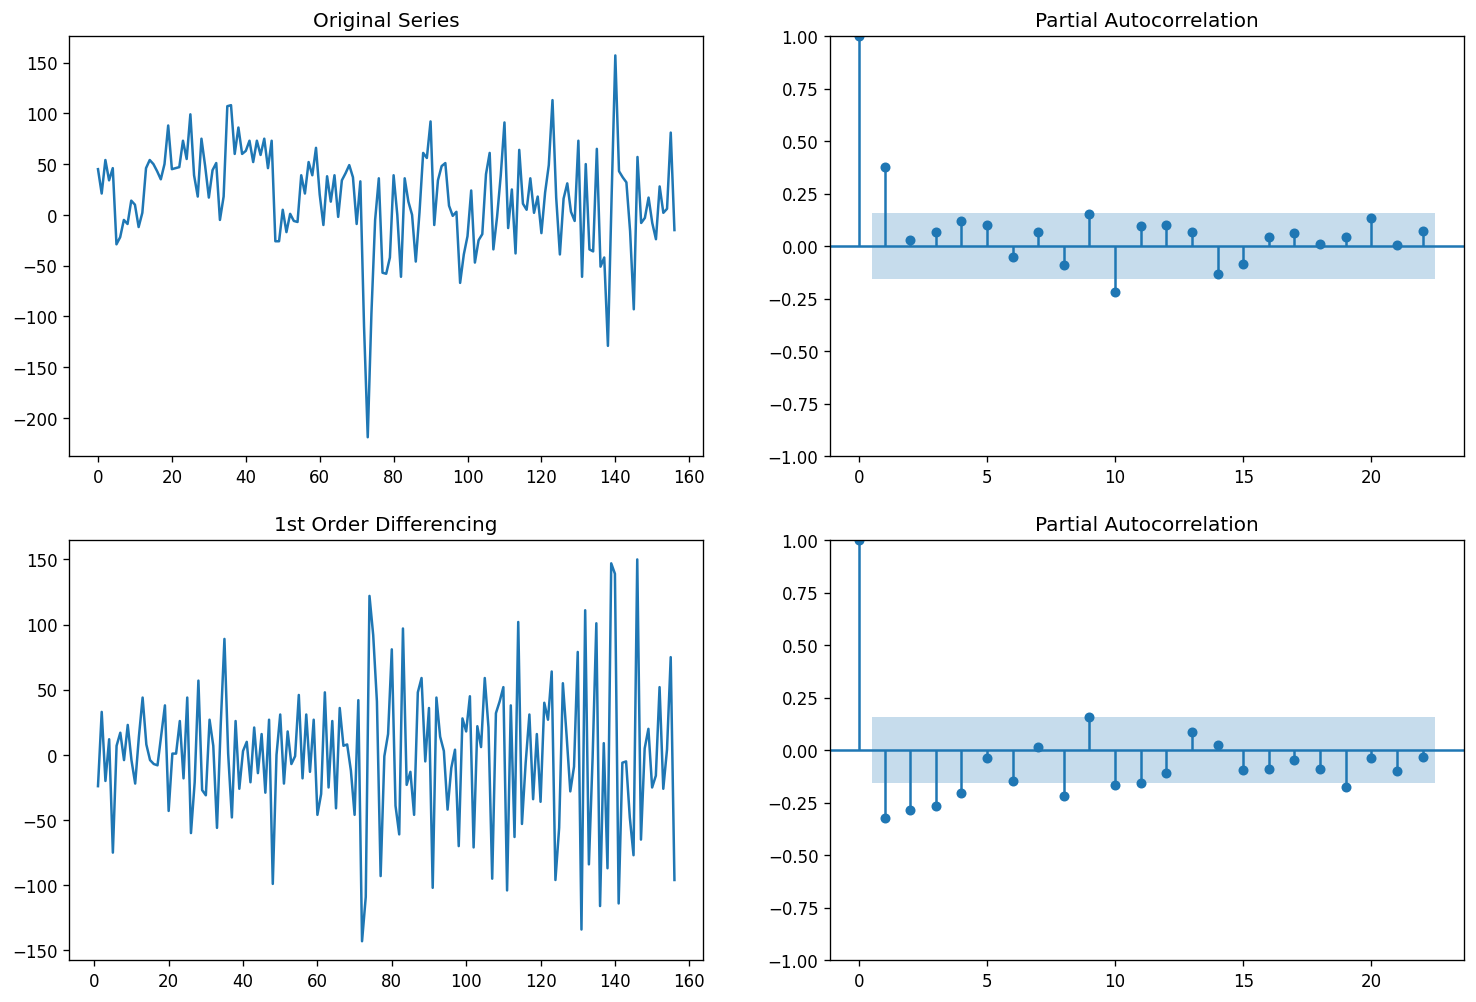

In [169]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(weekly_counts['Gain/Loss']); axes[0, 0].set_title('Original Series')
plot_pacf(weekly_counts['Gain/Loss'], ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(weekly_counts['Gain/Loss'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(weekly_counts['Gain/Loss'].diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

In [170]:
result = adfuller(weekly_counts['Gain/Loss'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.402014
p-value: 0.010890
Critical Values:
	1%: -3.476
	5%: -2.881
	10%: -2.577


In [172]:
result = adfuller(weekly_counts['Gain/Loss'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.846178
p-value: 0.000000
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.578


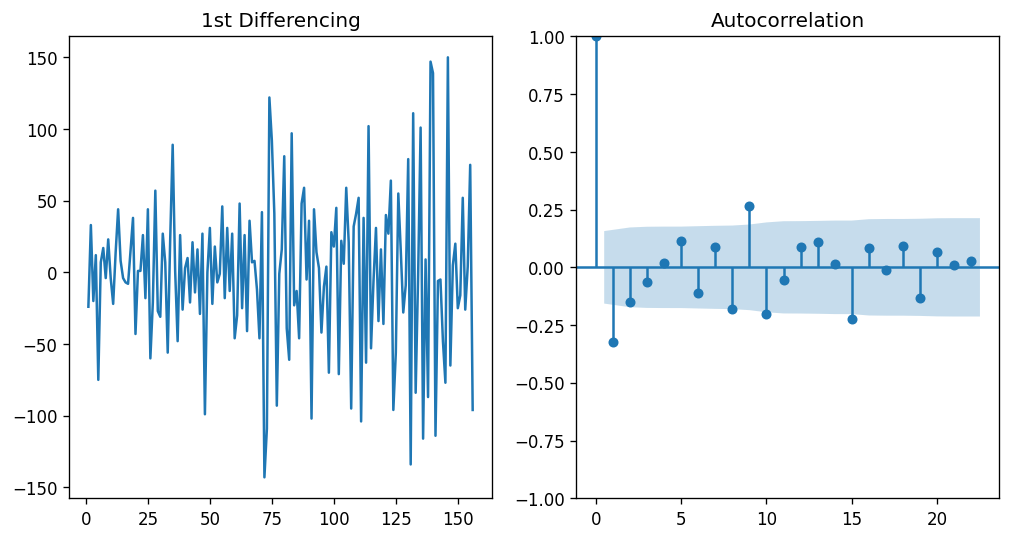

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(weekly_counts['Gain/Loss'].diff().dropna()); axes[0].set_title('1st Differencing')
plot_acf(weekly_counts['Gain/Loss'].diff().dropna(), ax=axes[1])

plt.show()


In [185]:
#try ARMA(7,1) = ARIMA(7,0,1)
P=1
D=1
Q=0

# fit model
N = 125  
series = weekly_counts['Gain/Loss'].reset_index(drop = True)

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Gain/Loss   No. Observations:                  125
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -641.032
Date:                Tue, 23 May 2023   AIC                           1286.064
Time:                        17:05:45   BIC                           1291.705
Sample:                             0   HQIC                          1288.356
                                - 125                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6301      0.057    -10.993      0.000      -0.742      -0.518
sigma2      1803.1174    166.240     10.846      0.000    1477.293    2128.942
Ljung-Box (L1) (Q):                   3.04   Jarque-

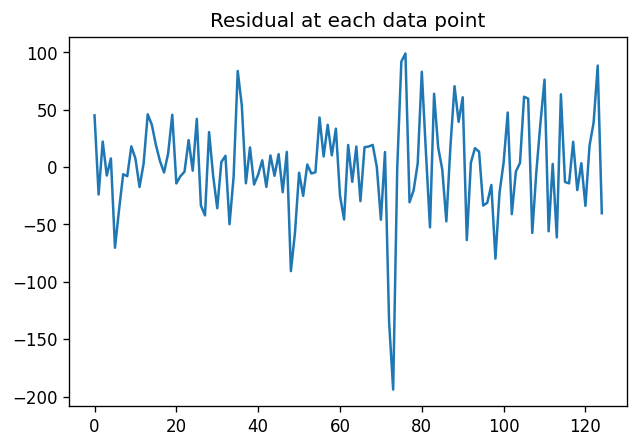

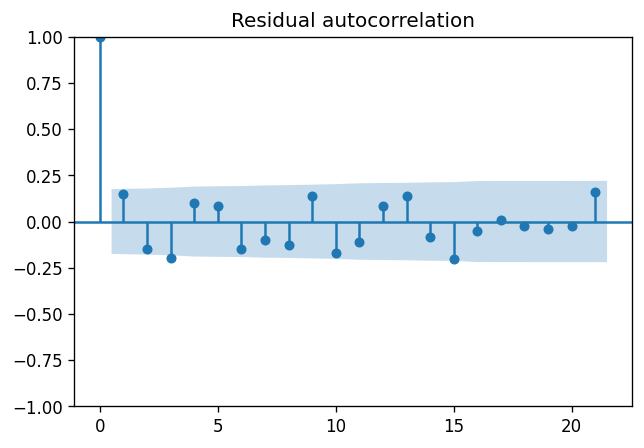

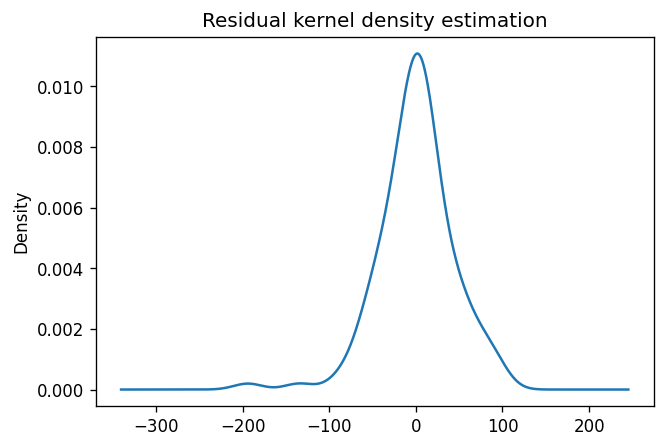

                0
count  125.000000
mean     0.375987
std     42.676948
min   -193.909259
25%    -20.336252
50%      2.709091
75%     19.193862
max     98.896231
p value is  3.8545720580028126e-06
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
      lb_stat  lb_pvalue
1    2.797267   0.094425
2    5.750826   0.056393
3   10.720820   0.013335
4   12.105767   0.016582
5   13.036414   0.023040
6   15.882996   0.014396
7   17.171849   0.016321
8   19.430691   0.012718
9   21.970250   0.008974
10  25.980186   0.003767


In [186]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})


# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


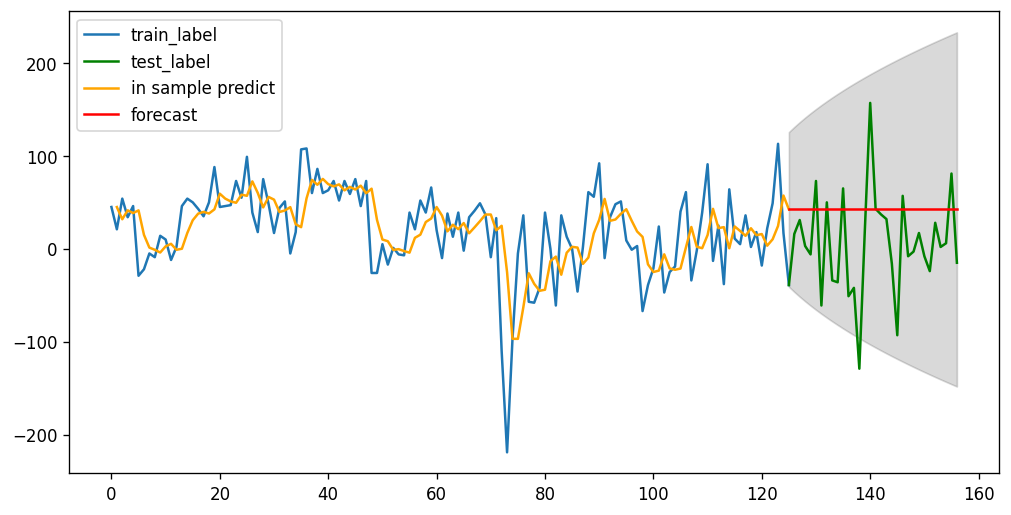

In [187]:
# Forecast
df = weekly_counts.reset_index(drop = True)
fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(df.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(df.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(df.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

In [188]:
fc

Gain/Loss,mean,mean_se,mean_ci_lower,mean_ci_upper
125,42.389095,42.463130,-40.837111,125.615300
126,42.389095,45.275676,-46.349599,131.127788
127,42.389095,47.923441,-51.539124,136.317313
128,42.389095,50.432386,-56.456566,141.234755
129,42.389095,52.822296,-61.140703,145.918893
130,42.389095,55.108660,-65.621893,150.400083
131,42.389095,57.303872,-69.924431,154.702620
132,42.389095,59.418037,-74.068118,158.846307
133,42.389095,61.459519,-78.069350,162.847539
134,42.389095,63.435336,-81.941880,166.720069


In [184]:
len(series)-N

57